### Skeletor benchmark
My main reason for making ``skeletor`` was/is to skeletonize meshes produced from segmentation of neural tissue. That's why we will be using publicly available meshes from the Janelia [hemibrain project](https://neuprint.janelia.org) for testing. Bear this in mind as neurons with their thin processes might collapse earlier than other meshes.

Other than ``skeletor`` and its dependencies, you will need the neuprint Python client, cloudvolume and seaborn:
```
$ pip install neuprint-python cloud-volume seaborn
```

In [51]:
import time

import cloudvolume as cv
import neuprint as neu
import numpy as np
import pandas as pd
import skeletor as sk

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes('muted')

# v1.1 is the most recent dataset at time of writing this benchmark
client = neu.Client('https://neuprint.janelia.org', dataset='hemibrain:v1.1')

In [2]:
# Find the mesh source
client.meta['neuroglancerMeta']

[{'dataInstance': 'grayscalejpeg',
  'dataType': 'image',
  'host': 'https://hemibrain-dvid.janelia.org',
  'name': 'grayscale',
  'source': 'precomputed://gs://neuroglancer-janelia-flyem-hemibrain/emdata/clahe_yz/jpeg'},
 {'dataInstance': 'segmentation',
  'dataType': 'segmentation',
  'host': 'https://hemibrain-dvid.janelia.org',
  'name': 'segmentation',
  'source': 'precomputed://gs://neuroglancer-janelia-flyem-hemibrain/segmentation_52a13'},
 {'annotationColor': '#ff0000',
  'dataInstance': 'public_annotations',
  'dataType': 'annotation',
  'host': 'https://hemibrain-dvid.janelia.org',
  'tool': 'annotatePoint',
  'uuid': '61c8'},
 {'dataInstance': 'synapses',
  'dataType': 'annotation',
  'host': 'https://hemibrain-dvid.janelia.org',
  'linkedSegmentationLayer': True,
  'name': 'synapses',
  'source': 'precomputed://gs://neuroglancer-janelia-flyem-hemibrain/synapses_52a13'}]

In [3]:
# Use the "segmentation" source
vol = cv.CloudVolume('precomputed://gs://neuroglancer-janelia-flyem-hemibrain/segmentation_52a13', fill_missing=True)

We will simply fetch a bunch of neurons of different sizes:

In [63]:
# Grab a list of neurons
neurons, _  = neu.fetch_neurons(neu.NeuronCriteria(status='Traced'))
neurons.head()

,bodyId,instance,type,pre,post,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
0,198469830,None,None,0,0,6663005,Traced,True,Leaves,None,299.0,"[33045, 15655, 3280]",[],[],{}
1,198810827,None,None,0,0,9211633,Traced,True,Leaves,None,299.0,"[33014, 16221, 3088]",[],[],{}
2,198815212,None,None,0,0,27720313,Traced,True,Leaves,None,299.0,"[33342, 16128, 3216]",[],[],{}
3,199147536,None,None,0,0,58523742,Traced,True,Leaves,None,299.0,"[32412, 16453, 3356]",[],[],{}
4,199156210,None,None,0,0,82392547,Traced,True,Leaves,None,299.0,"[33401, 16741, 3240]",[],[],{}


``size`` is their size in voxels and should co-relate with the complexity of the mesh. We will grab 10 neurons from very small to very large and skeletonize their meshes.

In [15]:
bodyid = 198469830
mesh = vol.mesh.get(bodyid, lod=2)[bodyid]
mesh

Mesh(vertices<346>, faces<756>, normals<0>, segid=None, encoding_type=<draco>)

In [16]:
def time_function(func, *args, **kwargs):
    """Time function."""
    start = time.time()
    res = func(*args, **kwargs)
    return res, (time.time() - start)

def benchmark_neuron(bodyid, lod=2):
    """Benchmark the collapse and skeletonization of a neuron.
    
    Returns
    -------
    list
            [bodyId, n_faces, collapse_time[s], vertex_cluster[s], edge_collapse[s]]
            
    """
    mesh = vol.mesh.get(bodyid, lod=lod)[bodyid]
    
    clps, clps_time = time_function(sk.contract, mesh, validate=True, progress=False)
    
    _, vc_time = time_function(sk.skeletonize, clps, method='vertex_clusters', validate=False, sampling_dist=100, progress=False)
    _, ec_time = time_function(sk.skeletonize, clps, method='edge_collapse', validate=False, progress=False)
    
    return [bodyid, mesh.faces.shape[0], clps_time, vc_time, ec_time]    

(0.0, 5000000000.0)

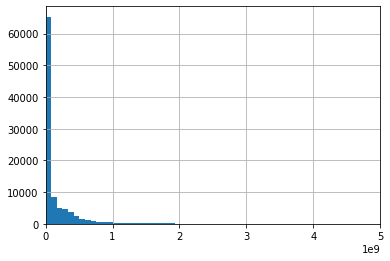

In [69]:
ax = neurons['size'].hist(bins=300)
ax.set_xlim(0, .5e10)

In [73]:
# Exclude some really small or really massive neurons and then bin by size
to_sample = neurons[(neurons['size'] <= 2e9) & (neurons['size'] >= 0.001e9)].copy()
to_sample['sizebin'] = pd.cut(to_sample['size'], bins=30)

# Pick one neuron per bin
to_sample = to_sample.groupby('sizebin').bodyId.first().values
to_sample = to_sample[~np.isnan(to_sample)]
to_sample

array([198469830, 199156210, 202230012, 202916528, 203240076, 206313858,
       263674097, 266187383, 203598466, 266187342, 266187477, 203594164,
       200326126, 266191395, 267223027, 295802733, 294791509, 265120597,
       295103172, 264083994, 263475451, 297912117, 297243542, 295816140,
       234630133, 233105330, 203253253, 294161385, 298616588, 268731005])

In [74]:
to_sample.shape

(30,)

In [75]:
# Benchmark
benched = pd.DataFrame([benchmark_neuron(b, lod=2) for b in tqdm(to_sample)],
                        columns=['bodyId', 'n_faces', 't_collapse', 't_vertex', 't_edge'])

In [76]:
benched.head()

,bodyId,n_faces,t_collapse,t_vertex,t_edge
0,198469830,756,0.482517,0.017278,0.247663
1,199156210,2158,1.295799,0.045239,1.203872
2,202230012,2389,1.653912,0.068088,1.345689
3,202916528,24024,11.667735,0.618897,50.982211
4,203240076,6860,4.556823,0.169309,9.064974


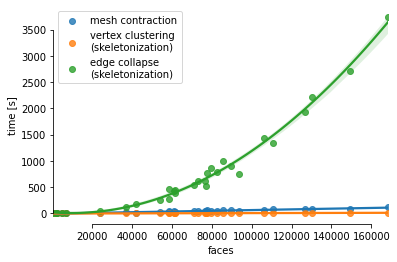

In [87]:
ax = sns.regplot(data=benched, x='n_faces', y='t_collapse', label='mesh contraction')
_ = sns.regplot(data=benched, x='n_faces', y='t_vertex', label='vertex clustering\n(skeletonization)', ax=ax)
_ = sns.regplot(data=benched, x='n_faces', y='t_edge', label='edge collapse\n(skeletonization)', order=2, ax=ax)

ax.legend()

ax.set_xlabel('faces')
ax.set_ylabel('time [s]')

sns.despine(trim=True)
plt.savefig('benchmark_1.png')

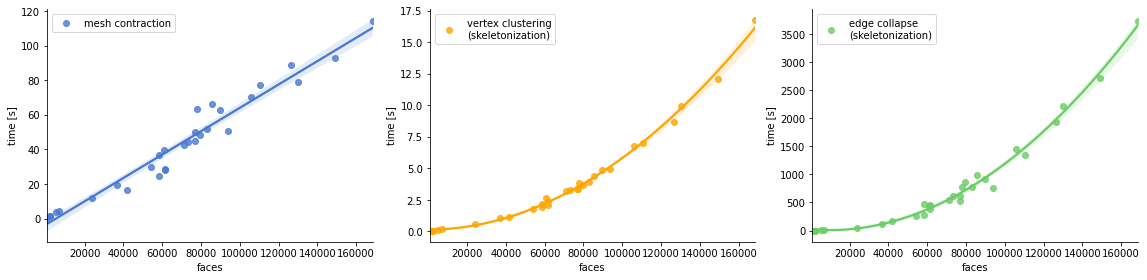

In [147]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

_ = sns.regplot(data=benched, x='n_faces', y='t_collapse', label='mesh contraction', ax=axes[0], color='b')
_ = sns.regplot(data=benched, x='n_faces', y='t_vertex', label='vertex clustering\n(skeletonization)', order=2, ax=axes[1], color='orange')
_ = sns.regplot(data=benched, x='n_faces', y='t_edge', label='edge collapse\n(skeletonization)', order=2, ax=axes[2], color='g')

for ax in axes:
    ax.legend()
    ax.set_xlabel('faces')
    ax.set_ylabel('time [s]')

sns.despine(trim=False)
plt.tight_layout()
plt.savefig('benchmark_2.png')